# Extracting Face from images
- The keras facenet model requires images of size 160x160
- The `#bugfix` is to fix the bug where sometimes negative coordinates are returned.

In [ ]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

def extract_face(filename, required_size=(160, 160)):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    
    #bugfix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    face = pixels[y1:y2, x1:x2]
    
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# Loading Face from Dataset
- This step may take some time.
- All faces are loaded and extracted along with their labels.
- They are saved in a compressed file at the end.
- Here we are loading both the *training* and *evaluation* data just for simplicity.

In [ ]:
def load_faces(directory):
    faces = list()
    for filename in listdir(directory):
        path = directory + filename
        face = extract_face(path)
        faces.append(face)
    return faces
    
def load_dataset(directory):
    x, y = list(), list()
    
    for subdir in listdir(directory):
        path = directory + subdir + '/'
        if not isdir(path):
            continue
        
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces))]
        
        print('> Loaded ', len(faces), 'examples for class : ', subdir)
        
        x.extend(faces)
        y.extend(labels)
    return asarray(x), asarray(y)

trainX, trainY = load_dataset('Data/train/')
testX, testY = load_dataset('Data/val/')
savez_compressed('Data/face_dataset.npz', trainX, trainY, testX, testY)

# Getting faces embeddings using the facenet model
- Each face is represented as 128 element vector.
- Embeddings for both the *training* and *evaluation* data are generated and stored in a compressed file along with their labels.

In [ ]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = expand_dims(face_pixels, axis = 0)
    
    prediction = model.predict(samples)
    return prediction[0]

data = load('Data/face_dataset.npz')
trainX, trainY, testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

model = load_model('Model/facenet_keras.h5')

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)

savez_compressed('Data/face_embeddings.npz', newTrainX, trainY, newTestX, testY)

# Perfoming Face Classification using Linear Support Vector Machine (SVM)
- 

Predicted: ben_afflek (87.304)
Expected: ben_afflek


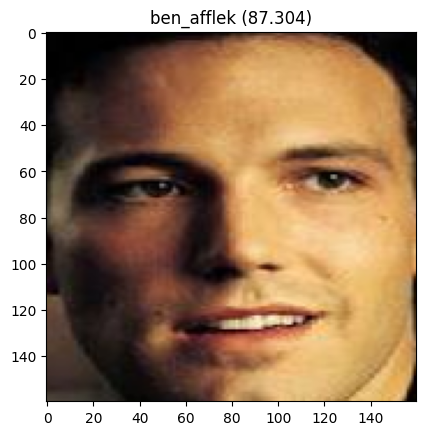

In [14]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot

# Loading Face Pixels
data = load('Data/face_dataset.npz')
testX_faces = data['arr_2']

# Loading Face Embeddings
data = load('Data/face_embeddings.npz')
trainX, trainY, testX, testY = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# Normalizing face vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# Encoding label strings associated with each face vector
out_encoder = LabelEncoder()
out_encoder.fit(trainY)
trainY = out_encoder.transform(trainY)
testY = out_encoder.transform(testY)

# Loading Model
model = SVC(kernel='linear', probability = True)
model.fit(trainX, trainY)

# Evaluating the model using a random face from the *evaluation* data
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testY[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

samples = expand_dims(random_face_emb, axis=0)
prediction_class = model.predict(samples)
prediction_prob = model.predict_proba(samples)

class_index = prediction_class[0]
class_probability = prediction_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(prediction_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show() 